Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [2]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    data = pd.concat([
        data,
        year_csv
    ]).reset_index(drop=True)

# Preprocessing

In [3]:
## Rainfall -------------------------------------------------------------------

def process_rainfall(df): # Removes races with rain
    rain = df.groupby(['Year', 'RoundNumber', 'DriverNumber'])['Compound'].transform(lambda x: x[x.str.contains('INTERMEDIATE|WET')].count())
    return df[rain == 0].reset_index(drop=True)

## Incomplete races -----------------------------------------------------------
def incomplete_races(df):
    return df.groupby(['Year', 'RoundNumber', 'DriverNumber']).filter(lambda x: x['LapNumber'].max() + 3 >= x['TotalLaps'].max()).reset_index(drop=True)
## TrackName ------------------------------------------------------------------

def process_track_name(df):
    df['Track'] = df['Track'].str.replace(' ', '_')
    return df
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': -1,
        'GapToLeader': -1,
        'IntervalToPositionAhead': -1,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1].reset_index(drop=True)

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    #df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    #df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate', 'Year', 'RoundNumber'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder

def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

In [4]:
def preprocess_pre_split(df):
    df = df.copy()
    print('Preprocessing data...', df.shape)
    df = process_rainfall(df)
    print('Rainfall processed...', df.shape)
    df = incomplete_races(df)
    df = process_track_name(df)
    print('TrackName processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    return df

def preprocess_post_split(df):
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_datatypes(df)
    print('Preprocessing data...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    return df

def preprocess_post_split_train(df):
    df = df.copy()
    df = process_target(df)
    print('Target processed...', df.shape)
    df, encoder = process_feature_encoding(df)
    print('Features encoded...', df.shape)

    df = preprocess_post_split(df)
    
    return df, encoder

def preprocess_post_split_test(df, encoder):
    df = df.copy()
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_feature_encoding_new(df, encoder)
    print('Features encoded...', df.shape)

    df = preprocess_post_split(df)

    return df

In [5]:
#%pip install imblearn

In [6]:
def get_races_grouped(df):
    return df.groupby(['Year', 'RoundNumber', 'DriverNumber'])

def get_train_test_split(df, test_size, return_groups=False):
    groups = get_races_grouped(df).groups
    groups_keys = list(groups.keys())
    np.random.shuffle(groups_keys)
    test_groups = groups_keys[:int(len(groups_keys) * test_size)]
    train_groups = groups_keys[int(len(groups_keys) * test_size):]
    test = df[df.apply(lambda x: (x['Year'], x['RoundNumber'], x['DriverNumber']) in test_groups, axis=1)].reset_index(drop=True)
    train = df[df.apply(lambda x: (x['Year'], x['RoundNumber'], x['DriverNumber']) in train_groups, axis=1)].reset_index(drop=True)
    if return_groups:
        return train, test, train.groupby(['Year', 'RoundNumber', 'DriverNumber']).groups, test.groupby(['Year', 'RoundNumber', 'DriverNumber']).groups
    return train, test

In [7]:
df = data.copy()
df = preprocess_pre_split(df)

Preprocessing data... (89139, 29)
Rainfall processed... (78346, 29)
TrackName processed... (73105, 29)
Missing values processed... (70689, 29)


In [8]:
train_df, test_df, train_groups, test_groups = get_train_test_split(df.copy(), test_size=0.2, return_groups=True)

In [9]:
train_df, encoder = preprocess_post_split_train(train_df)
test_df = preprocess_post_split_test(test_df, encoder)

In [ ]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

X_train = train_df.drop(['is_pitting'], axis=1)
y_train = train_df['is_pitting']

X_test = test_df.drop(['is_pitting'], axis=1)
y_test = test_df['is_pitting']

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(56570, 49) (14119, 49) (56570,) (14119,)


# Modelisation

In [ ]:
def calculate_distance_to_next_true(series):
    # Find the indices of True values
    true_indices = np.where(series)[0]
    true_indices = np.concatenate((true_indices, [len(series)]))

    distance_to_next_true = np.zeros(len(series))
    for i in range(len(series)):
        sorted_indices = np.searchsorted(true_indices, i)
        if sorted_indices == len(true_indices) - 1:
            distance_to_next_true[i] = len(series)
        else:
            distance_to_next_true[i] = true_indices[sorted_indices] - i

    # Replace the True values by the distance to the next True value
    result_series = pd.Series(distance_to_next_true)
    
    return result_series

def calculate_weight(proba, distance_to_pit, threshold=0.5, penalty=1):
    if distance_to_pit <= 0:
        return proba
    elif proba >= threshold: # Means that the model predicted a pitstop but it didn't happen
        #return distance_to_pit * (1 - (1 + penalty) * proba)
        #return distance_to_pit * penalty * -(-proba + threshold)**2
        return -proba
    else:
        return 0
    
def calculate_weights(preds, nb_pitstops, threshold=0.5, penalty=1):
    distances = calculate_distance_to_next_true(preds['y'])
    weights = []
    last_pit = 0
    for i in range(len(preds['y'])):
        proba = preds['proba'][i]
        distance = distances[i]
        weight = calculate_weight(proba, distances[i], threshold=threshold, penalty=penalty)
        
        if distance == 0 or i == len(preds['y']) - 1:
            if i == len(preds['y']) - 1:
                weights.append(weight)
            coef_for_laps = distances[last_pit + 1:i]
            weights_for_laps = weights[last_pit + 1:i]
            weights[last_pit + 1:i] = coef_for_laps * weights_for_laps / sum(coef_for_laps)
            if distance == 0:
                last_pit = i

        if i != len(preds['y']) - 1:
            weights.append(weight)
    
    return np.divide(weights, nb_pitstops)

def plot_remove_duplicate_legends(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), **kwargs)
    return ax

def plot_weights(ax, weights):
    ax.grid(True)
    weights_cumsum = np.cumsum(weights)
    ax.plot(weights_cumsum)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [ ]:
from tensorflow import keras
class RacePerformanceMetricCallback(keras.callbacks.Callback):
    def __init__(self, df_val, x_val, y_val, groups, threshold=0.5, penalty=0.5, verbose=1):
        super(RacePerformanceMetricCallback, self).__init__()
        self.df_val = df_val
        self.x_val = x_val
        self.y_val = y_val
        self.threshold = threshold
        self.penalty = penalty
        self.groups = groups
        self.score_history = []
        self.verbose = verbose
    def on_train_begin(self, logs=None):
        self.score_history = []
    def on_epoch_end(self, epoch, logs=None):
        average_score = 0
        for group, laps in self.groups.items(): # Make preds for each race separately
            preds = self.model.predict(self.x_val[laps], verbose=self.verbose)
            preds = pd.DataFrame(preds, columns=['proba'])
            preds['y'] = self.y_val[laps]
            weights = calculate_weights(preds, self.df_val.iloc[laps]['NumberOfPitStops'].iloc[-1])
            average_score += np.sum(weights)
        average_score /= len(self.groups)
        self.score_history.append(average_score)
    def on_train_end(self, logs=None):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        plot_score_history(ax, self.score_history)
        plt.show()
        self.model = None

def plot_score_history(ax, score_history):
    ax.grid(True)
    ax.plot(score_history)
    ax.set_autoscaley_on(True)
    return plot_remove_duplicate_legends(ax)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix

import tensorflow.keras.backend as K

def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return (specificity + sensitivity) / 2

def balanced_accuracy_loss(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    specificity = tn / (tn + fp + K.epsilon())
    sensitivity = tp / (tp + fn + K.epsilon())
    return (specificity + sensitivity) / 2

In [ ]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.5142633770295085, 1: 18.02740599107712}

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam

def create_model(layers_param, dropout_param, learning_rate_param):
    input_dim = X_train.shape[1]
    # Create model
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for i in range(len(layers_param)):
        model.add(layers.Dense(layers_param[i], activation='relu'))
        if len(dropout_param) > i and dropout_param[i] > 0:
            model.add(layers.Dropout(dropout_param[i]))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(
        learning_rate=learning_rate_param,
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[balanced_accuracy_loss],
        )
    
    return model

In [ ]:
best_params = {
    'layers': [1024, 1024, 512, 256],
    'dropout': [0.2, 0.2, 0.2],
    'learning_rate': 0.0005,
    'batch_size': 256,
    'epochs': 300,
    'class_weights': class_weights,
    'callbacks': [RacePerformanceMetricCallback(test_df, X_test, y_test, test_groups, verbose=0)]
}

In [ ]:
model = create_model(best_params['layers'], best_params['dropout'], best_params['learning_rate'])

hist = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1,
    callbacks=best_params['callbacks'],
    class_weight=best_params['class_weights'],
)

Epoch 1/1000
221/221 [==============================] - 16s 70ms/step - loss: 0.7676 - balanced_accuracy_loss: 0.5334 - val_loss: 0.5797 - val_balanced_accuracy_loss: 0.5570
Epoch 2/1000
221/221 [==============================] - 14s 65ms/step - loss: 0.6301 - balanced_accuracy_loss: 0.5611 - val_loss: 0.5290 - val_balanced_accuracy_loss: 0.5853
Epoch 3/1000
221/221 [==============================] - 13s 60ms/step - loss: 0.6179 - balanced_accuracy_loss: 0.5817 - val_loss: 0.6880 - val_balanced_accuracy_loss: 0.6008
Epoch 4/1000
221/221 [==============================] - 12s 55ms/step - loss: 0.5975 - balanced_accuracy_loss: 0.5934 - val_loss: 0.5145 - val_balanced_accuracy_loss: 0.6288
Epoch 5/1000
221/221 [==============================] - 12s 56ms/step - loss: 0.5880 - balanced_accuracy_loss: 0.6052 - val_loss: 0.5273 - val_balanced_accuracy_loss: 0.6085
Epoch 6/1000
221/221 [==============================] - 12s 56ms/step - loss: 0.5778 - balanced_accuracy_loss: 0.6115 - val_loss: 

: 

: 

In [ ]:
y_pred = model.predict(X_test)

442/442 [==============================] - 0s 1ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test, y_pred.round()))

[[12137  1590]
 [   72   320]]
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.94     13727
         1.0       0.17      0.82      0.28       392

    accuracy                           0.88     14119
   macro avg       0.58      0.85      0.61     14119
weighted avg       0.97      0.88      0.92     14119



In [ ]:
import pickle
# Save model
models_dir = 'models/nn_best_new_metrics_1024'
os.makedirs(models_dir, exist_ok=True)
model.save(os.path.join(models_dir, 'model.h5'))
encoder_path = os.path.join(models_dir, 'encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder, f)

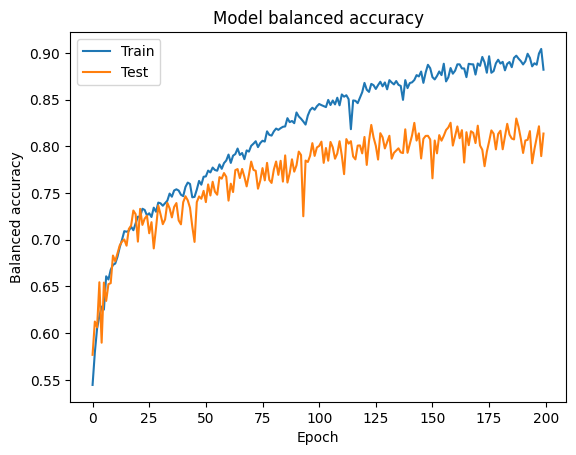

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['balanced_accuracy_loss'])
plt.plot(hist.history['val_balanced_accuracy_loss'])
plt.title('Model balanced accuracy')
plt.ylabel('Balanced accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(os.path.join(models_dir, 'balanced_accuracy.svg'), format='svg')
plt.show()